# Longitudinal Analysis

### Import packages

In [1]:
import paramiko
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from leaspy import Leaspy, Data, AlgorithmSettings, IndividualParameters

### SSH Connection + file read

In [2]:
hostname = 'bridges2.psc.edu'
username = 'amanov'
password = '110388+neuro'

remote_path_baseline_mm = '/ocean/projects/med230011p/shared/data_rep/abcd/baseline/trks/mean length(mm).csv'
remote_path_2yr_mm = '/ocean/projects/med230011p/shared/data_rep/abcd/2yrfollowup/trks/mean length(mm).csv'
remote_path_4yr_mm = '/ocean/projects/med230011p/shared/data_rep/abcd/4yrfollowup/trks/mean length(mm).csv'

client = paramiko.SSHClient()
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(hostname, username=username, password=password)
print('SSH connection established')

sftp = client.open_sftp()

print('reading requested files')
    
with sftp.open(remote_path_baseline_mm, 'r') as remote_file:
    csv_content_baseline_mm = remote_file.read()

with sftp.open(remote_path_2yr_mm, 'r') as remote_file:
    csv_content_2yr_mm = remote_file.read()

with sftp.open(remote_path_4yr_mm, 'r') as remote_file:
    csv_content_4yr_mm = remote_file.read()

print('files read')

sftp.close()
client.close()
print('SSH connection closed')


SSH connection established
reading requested files
files read
SSH connection closed


### Dataframe modification

In [3]:
data_baseline = pd.read_csv(StringIO(csv_content_baseline_mm.decode('utf-8')))
data_2yr = pd.read_csv(StringIO(csv_content_2yr_mm.decode('utf-8')))
data_4yr = pd.read_csv(StringIO(csv_content_4yr_mm.decode('utf-8')))

data_baseline.rename(columns={data_baseline.columns[0]: 'ID'}, inplace=True)
data_2yr.rename(columns={data_2yr.columns[0]: 'ID'}, inplace=True)
data_4yr.rename(columns={data_4yr.columns[0]: 'ID'}, inplace=True)

### The next 2 code cells are **mutually exclusive**. Only choose one code cell to run before creating plot.
_________

OPTION 1: <span style="color:red;">Run code cell below for **FULL** dataset</span>

In [4]:
#insert new column after ID column
data_baseline.insert(1, 'TIME', 'baseline')
data_2yr.insert(1, 'TIME', '2yr')
data_4yr.insert(1, 'TIME', '4yr')

data_baseline['TIME'] = 0
data_2yr['TIME'] = 2
data_4yr['TIME'] = 4

combined_data = pd.concat([data_baseline, data_2yr, data_4yr], ignore_index=True)

In [ ]:
combined_data.to_csv('/Users/armanimanov/Desktop/neurosurg/combined_data_longitudinal.csv', index=False)

OPTION 2: <span style="color:red;">Run code cell below for **n=X sampled** dataset</span>

In [ ]:
sampled_baseline = data_baseline.sample(n=100, random_state=42)
sampled_2yr = data_2yr[data_2yr['ID'].isin(sampled_baseline['ID'])]
sampled_4yr = data_4yr[data_4yr['ID'].isin(sampled_baseline['ID'])]

sampled_baseline['TIME'] = 0
sampled_2yr['TIME'] = 2
sampled_4yr['TIME'] = 4

combined_data = pd.concat([sampled_baseline, sampled_2yr, sampled_4yr], ignore_index=True)

__________

In [6]:
duplicates = combined_data.duplicated(subset=['ID', 'TIME'], keep=False)
print(duplicates)
#data = combined_data.drop_duplicates(subset=['ID', 'TIME'], keep='first')
#print(data)

0        False
1        False
2        False
3        False
4        False
         ...  
19641    False
19642    False
19643    False
19644    False
19645    False
Length: 19646, dtype: bool


In [5]:
df = combined_data

robust_min = df.iloc[:, 2:].quantile(0.01)
robust_max = df.iloc[:, 2:].quantile(0.99)

df.iloc[:, 2:] = (df.iloc[:, 2:] - robust_min) / (robust_max - robust_min)

df.iloc[:, 2:] = df.iloc[:, 2:].clip(lower=0, upper=1)

fts_min_max = df.iloc[:, 2:].agg(['min', 'max'])

assert (fts_min_max.loc['min'] >= 0).all(), "Some minimum values are below 0."
assert (fts_min_max.loc['max'] <= 1).all(), "Some maximum values are above 1."

pd.options.display.float_format = '{:.2f}'.format

data = Data.from_dataframe(df) 
fts_min_max


,Association_ArcuateFasciculusL,Association_ArcuateFasciculusR,Association_CingulumL_FrontalParahippocampal,Association_CingulumL_FrontalParietal,Association_CingulumL_SuperiorLongitudinalFasciculus1,Association_CingulumL_ParahippocampalParietal,Association_CingulumL_Parahippocampal,Association_CingulumL_Parolfactory,Association_CingulumR_FrontalParahippocampal,Association_CingulumR_FrontalParietal,...,CranialNerve_CNIIL,CranialNerve_CNIIR,CranialNerve_CNIIIL,CranialNerve_CNIIIR,CranialNerve_CNVL,CranialNerve_CNVR,CranialNerve_CNVIIL,CranialNerve_CNVIIR,CranialNerve_CNVIIIL,CranialNerve_CNVIIIR
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [7]:
algo_settings = AlgorithmSettings('mcmc_saem', 
                                  n_iter=1,           # n_iter defines the number of iterations
                                  progress_bar=True)     # To display a nice progression bar during calibration

algo_settings.set_logs(
    path='outputs/logs', # Creates a logs file ; if existing, ask if rewrite it
    save_periodicity=50, # Saves the values in csv files every N iterations
    console_print_periodicity=100, # Displays logs in the console/terminal every N iterations, or None
    plot_periodicity=1000, # Generates the convergence plots every N iterations
    overwrite_logs_folder=True # if True and the logs folder already exists, it entirely overwrites it
)

leaspy = Leaspy("logistic", 
                source_dimension=15, # Optional
                noise_model='gaussian_diagonal', # Optional: To get a noise estimate per feature keep it this way (default)
                )

/Users/armanimanov/anaconda3/envs/vsc/lib/python3.9/site-packages/leaspy/io/settings/outputs_settings.py:122: UserWarning: The logs path you provided (/Users/armanimanov/tractography/longitudinal-analysis/outputs/logs) does not exist. Needed paths will be created (and their parents if needed).
  warnings.warn(f"The logs path you provided ({settings['path']}) does not exist. "


In [8]:
leaspy.fit(data, settings=algo_settings)

|-|   0/1 iterations

/Users/armanimanov/anaconda3/envs/vsc/lib/python3.9/site-packages/leaspy/models/utils/initialization/model_initialization.py:323: UserWarning: Mean slope of individual linear regressions made at initialization is negative for ['Association_CingulumL_Parolfactory', 'Association_CingulumR_ParahippocampalParietal', 'Association_HippocampusAlveusL', 'Association_HippocampusAlveusR', 'Association_InferiorLongitudinalFasciculusR', 'Association_ParietalAslantTractL', 'Association_ParietalAslantTractR', 'Association_VerticalOccipitalFasciculusL', 'Association_VerticalOccipitalFasciculusR', 'ProjectionBasalGanglia_CorticostriatalTractL_Posterior', 'ProjectionBasalGanglia_CorticostriatalTractR_Posterior', 'ProjectionBasalGanglia_ThalamicRadiationL_Posterior', 'ProjectionBasalGanglia_ThalamicRadiationL_Superior', 'ProjectionBasalGanglia_ThalamicRadiationR_Posterior', 'ProjectionBasalGanglia_ThalamicRadiationR_Superior', 'ProjectionBasalGanglia_OpticRadiationL', 'ProjectionBasalGanglia_OpticRadiat


=== ALGO ===
Instance of mcmc_saem algo [CPU]
Iteration 1 / 1
= Samplers =
    g rate : 3.7%, std: 1.5e-03
    v0 rate : 2.1%, std: 4.5e-02
    tau rate : 2.0%, std: 2.5e+00
    xi rate : 2.3%, std: 2.5e-01
    sources rate : 1.4%, std: 5.0e-01
    betas rate : 1.2%, std: 5.0e-03

=== MODEL ===
g : [ 0.0471, -0.5217, -0.0505,  0.0254, -0.0050,  0.0287, -0.0252, -0.0159,
        -0.3611, -0.0177, -0.0838, -0.0887, -0.1453, -0.3781,  0.1228,  0.1228,
        -0.0670, -0.0561,  0.0426, -0.0094,  0.0074,  0.0272, -0.0198, -0.0567,
        -0.8165, -0.5951, -0.2181, -0.2363, -0.1051, -0.1192, -0.1426,  0.0241,
         0.0221, -0.0240, -0.0095, -0.0305,  0.0035,  0.0663, -0.1283,  0.1965,
         0.0871,  0.0319,  0.0937,  0.0695, -0.1189,  0.1258,  0.0312, -0.0317,
         0.0522,  0.0230,  0.1301,  0.1431,  0.0461,  0.0742,  0.2615,  0.2977,
         0.2887,  0.2090,  0.4769,  0.4781,  0.0806,  0.1155,  0.0310,  0.0449,
        -0.8880, -0.9558,  0.0019,  0.0418,  0.0311, -0.0200,  0.0

In [9]:
# —— get avg individual parameters
mean_xi = leaspy.model.parameters['xi_mean'].numpy()
mean_tau = leaspy.model.parameters['tau_mean'].numpy()
mean_source = leaspy.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— store avg individual parameters in dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)

In [10]:
cmap = plt.cm.get_cmap('viridis', 110)
colors = [cmap(i) for i in range(110)]

/var/folders/ly/h11_g_5s5h1g79qz7rjq567r0000gn/T/ipykernel_77065/207864886.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 110)


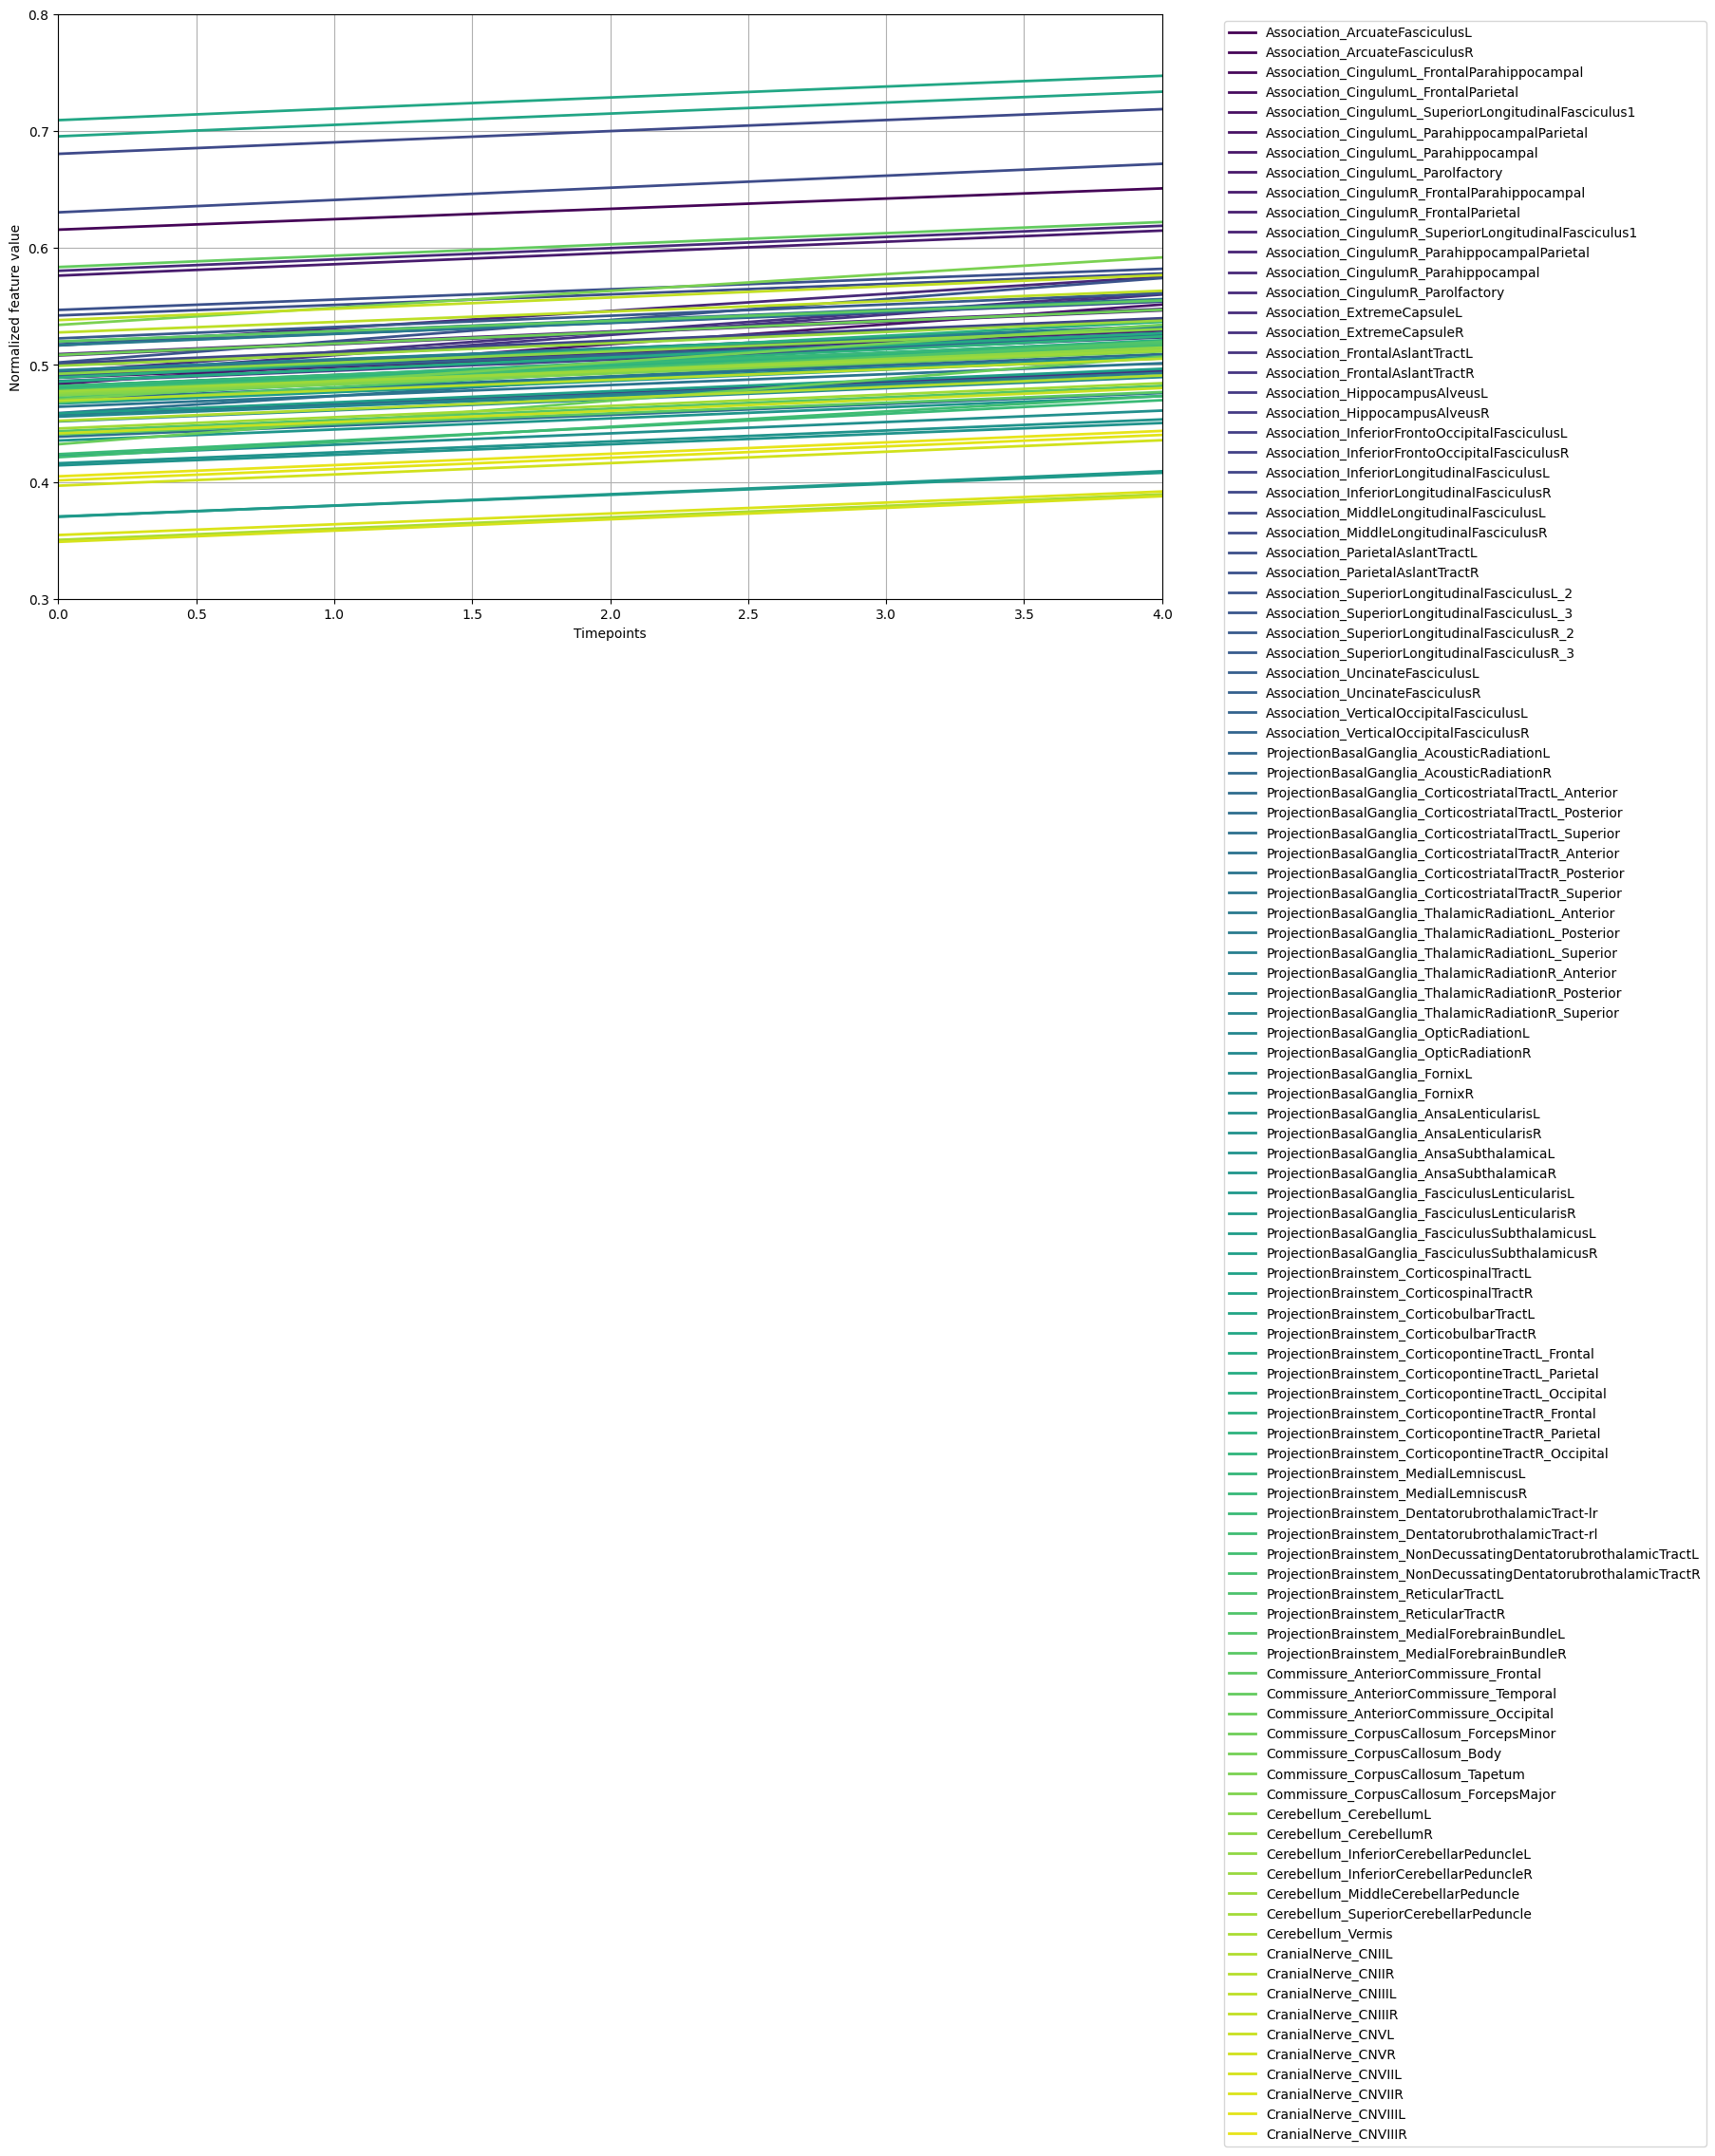

In [11]:
timepoints = np.linspace(0, 4)
values = leaspy.estimate({'average': timepoints}, ip_average)

def plot_trajectory(timepoints, reconstruction, observations=None, *, 
                    xlabel='Timepoints', ylabel='Normalized feature value'):
    
    plt.figure(figsize=(15, 8))
    plt.ylim(0.3, 0.8)
    
    if observations is not None:
        ages = observations.index.values
    
    for i, (name, val) in enumerate(zip(leaspy.model.features, reconstruction.T)):
        plt.plot(timepoints, val, label=name, c=colors[i], linewidth=2)
        if observations is not None:
            plt.plot(ages, observations[name], c=colors[i], marker='o', markersize=5, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()

plot_trajectory(timepoints, values['average'])